In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhishektyagi001/vehicle-make-model-recognition-dataset-vmmrdb")

print("Path to dataset files:", path)

100%|██████████| 462M/462M [00:08<00:00, 59.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhishektyagi001/vehicle-make-model-recognition-dataset-vmmrdb/versions/1


In [2]:

cd /root/.cache/kagglehub/datasets/abhishektyagi001/vehicle-make-model-recognition-dataset-vmmrdb/versions/1/Dataset/

/root/.cache/kagglehub/datasets/abhishektyagi001/vehicle-make-model-recognition-dataset-vmmrdb/versions/1/Dataset


In [15]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Configuration
DEBUG = False
EPOCHS = 20
MOMENTUM = 0.9
LEARNING_RATE = 0.01
BATCH_SIZE = 128
THREADS = 20
USE_CUDA = torch.cuda.is_available()

# Dataset Path
IMAGES_PATH = "/root/.cache/kagglehub/datasets/abhishektyagi001/vehicle-make-model-recognition-dataset-vmmrdb/versions/1/Dataset/Most_Stolen_Cars"

# Check if dataset exists
if not os.path.exists(IMAGES_PATH):
    raise FileNotFoundError(f"Dataset folder not found: {IMAGES_PATH}")


In [5]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Dataset
full_dataset = ImageFolder(root=IMAGES_PATH, transform=transform)

# Print Class Mapping
print("Class Mapping:", full_dataset.class_to_idx)

# Split Dataset (80% Train, 10% Validation, 10% Test)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=THREADS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=THREADS)

# Device Selection
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using device: {device}")


Class Mapping: {'chevrolet_impala_2008': 0, 'chevrolet_silverado_2004': 1, 'dodge_ram_2001': 2, 'ford_f150_2006': 3, 'gmc_sierra_2012': 4, 'honda_accord_1997': 5, 'honda_civic_1998': 6, 'nissan_altima_2014': 7, 'toyota_camry_2014': 8, 'toyota_corolla_2013': 9}
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Define Custom ResNet50 Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes, activation='relu'):
        super(CustomResNet, self).__init__()
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Choose activation function
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU()

        # Modify Fully Connected Layer
        self.model.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.model(x)

# Custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)  # Adjust the size based on the input image dimensions
        # Calculate the correct input size for fc1
        # After 3 pooling layers with kernel size 2 and stride 2, the image size is reduced by 2^3 = 8
        # So, the feature map size will be (224 / 8, 224 / 8) = (28, 28) for an input image of size (224, 224)

        # Calculate the size of the flattened feature map: channels * height * width = 256 * 28 * 28
        # self.fc1 input size should be equal to the size of the flattened feature map (output from the convolutional layers)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)  # Changed the input size for fc1

        self.fc2 = nn.Linear(1024, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Calculate the size of the flattened feature map
        # After 3 MaxPooling Layers with a Kernel size of 2, and a stride of 2 the output dimension is 28x28
        # The number of output channels from the final convolutional layer is 256
        # Therefore, the input size for the first linear layer should be 256x28x28 (Reshaped into a linear layer)

        x = x.view(-1, 256 * 28 * 28)  # Flatten before feeding into fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def classify_random_image(model, dataset, device):
    model.eval()

    # Select a random image from the test dataset
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)

    # Get the model's prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)  # Get probabilities
        confidence, predicted_class = torch.max(probs, 1)

    # Denormalize the image for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_denormalized = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

    # Display the image and classification result
    plt.figure(figsize=(5, 5))
    plt.imshow(img_denormalized.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(f"Actual: {full_dataset.classes[label]}\n"
              f"Predicted: {full_dataset.classes[predicted_class.item()]}\n"
              f"Confidence Score: {confidence.item() * 100:.2f}%")
    plt.show()


In [7]:
# Initialize Model
num_classes = len(full_dataset.classes)
model = CustomResNet(num_classes=num_classes).to(device)

# Initialize CNN Model
cnn_model = CustomCNN(num_classes=num_classes).to(device)

# Define CNN Loss & Optimizer
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Training Loop for CNN Model
cnn_train_losses, cnn_val_losses = [], []

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.8MB/s]


In [8]:
# Training Loop with Progress Bar
train_losses, val_losses = [], []

print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loss Calculation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Training Loop for CNN Model
cnn_train_losses, cnn_val_losses = [], []

print("Starting CNN Training...")
for epoch in range(EPOCHS):
    cnn_model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"CNN Epoch {epoch+1}/{EPOCHS}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        cnn_optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        cnn_optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    cnn_train_losses.append(avg_train_loss)

    # Validation Loss Calculation
    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    cnn_val_losses.append(avg_val_loss)

    print(f"CNN Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Starting Training...


Epoch [1/20] | Train Loss: 1.7587 | Val Loss: 0.9783


Epoch [2/20] | Train Loss: 0.5970 | Val Loss: 0.3650


Epoch [3/20] | Train Loss: 0.1510 | Val Loss: 0.2692


Epoch [4/20] | Train Loss: 0.0370 | Val Loss: 0.1742


Epoch [5/20] | Train Loss: 0.0136 | Val Loss: 0.1641


Epoch [6/20] | Train Loss: 0.0069 | Val Loss: 0.1583


Epoch [7/20] | Train Loss: 0.0048 | Val Loss: 0.1595


Epoch [8/20] | Train Loss: 0.0033 | Val Loss: 0.1568


Epoch [9/20] | Train Loss: 0.0027 | Val Loss: 0.1574


Epoch [10/20] | Train Loss: 0.0020 | Val Loss: 0.1535


Epoch [11/20] | Train Loss: 0.0016 | Val Loss: 0.1522


Epoch [12/20] | Train Loss: 0.0013 | Val Loss: 0.1554


Epoch [13/20] | Train Loss: 0.0012 | Val Loss: 0.1561


Epoch [14/20] | Train Loss: 0.0011 | Val Loss: 0.1514


Epoch [15/20] | Train Loss: 0.0010 | Val Loss: 0.1523


Epoch [16/20] | Train Loss: 0.0009 | Val Loss: 0.1550


Epoch [17/20] | Train Loss: 0.0008 | Val Loss: 0.1528


Epoch [18/20] | Train Loss: 0.0008 | Val Loss: 0.1509


Epoch [19/20] | Train Loss: 0.0007 | Val Loss: 0.1531


Epoch [20/20] | Train Loss: 0.0006 | Val Loss: 0.1487
Starting CNN Training...


CNN Epoch [1/20] | Train Loss: 2.1780 | Val Loss: 2.0448


CNN Epoch [2/20] | Train Loss: 1.9861 | Val Loss: 1.8975


CNN Epoch [3/20] | Train Loss: 1.7989 | Val Loss: 1.8430


CNN Epoch [4/20] | Train Loss: 1.5770 | Val Loss: 1.7805


CNN Epoch [5/20] | Train Loss: 1.3357 | Val Loss: 1.8647


CNN Epoch [6/20] | Train Loss: 0.9640 | Val Loss: 1.8944


CNN Epoch [7/20] | Train Loss: 0.4857 | Val Loss: 2.3373


CNN Epoch [8/20] | Train Loss: 0.1940 | Val Loss: 3.0200


CNN Epoch [9/20] | Train Loss: 0.0485 | Val Loss: 3.5592


CNN Epoch [10/20] | Train Loss: 0.0246 | Val Loss: 3.9619


CNN Epoch [11/20] | Train Loss: 0.0391 | Val Loss: 3.4290


CNN Epoch [12/20] | Train Loss: 0.0240 | Val Loss: 4.0259


CNN Epoch [13/20] | Train Loss: 0.0110 | Val Loss: 4.0796


CNN Epoch [14/20] | Train Loss: 0.0060 | Val Loss: 4.1371


CNN Epoch [15/20] | Train Loss: 0.0015 | Val Loss: 4.2436


CNN Epoch [16/20] | Train Loss: 0.0004 | Val Loss: 4.3553


CNN Epoch [17/20] | Train Loss: 0.0002 | Val Loss: 4.4370


CNN Epoch [18/20] | Train Loss: 0.0002 | Val Loss: 4.5089


CNN Epoch [19/20] | Train Loss: 0.0001 | Val Loss: 4.5666


CNN Epoch [20/20] | Train Loss: 0.0001 | Val Loss: 4.6192


In [9]:
# Save Model
torch.save(model.state_dict(), "car_model.pth")
print("ResNet Model Training Complete & Saved!")

# Save CNN Model
torch.save(cnn_model.state_dict(), "cnn_car_model.pth")
print("CNN Model Training Complete & Saved!")

ResNet Model Training Complete & Saved!
CNN Model Training Complete & Saved!


In [10]:
# Validation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"ResNet alidation Accuracy: {100 * correct / total:.2f}%")


# Validation for CNN
cnn_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"CNN Validation Accuracy: {100 * correct / total:.2f}%")

ResNet alidation Accuracy: 95.26%
CNN Validation Accuracy: 42.47%


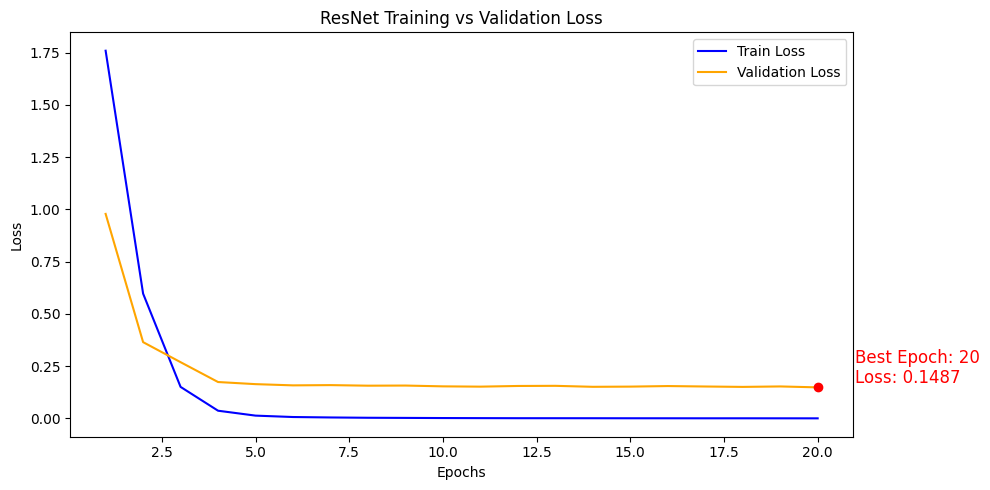

In [11]:
# Find the best epoch (minimum validation loss)
best_epoch = np.argmin(val_losses) + 1  # Add 1 to match epoch numbering
best_val_loss = min(val_losses)

# Plot Training & Validation Loss for Resnet
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, EPOCHS+1), val_losses, label="Validation Loss", color='orange')

# Highlight the best epoch
plt.scatter(best_epoch, best_val_loss, color="red", zorder=5)
plt.text(best_epoch + 1, best_val_loss, f"Best Epoch: {best_epoch}\nLoss: {best_val_loss:.4f}",
         fontsize=12, color="red", verticalalignment="bottom")

# Add labels, legend, and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet Training vs Validation Loss")

# Show the plot
plt.tight_layout()
plt.show()

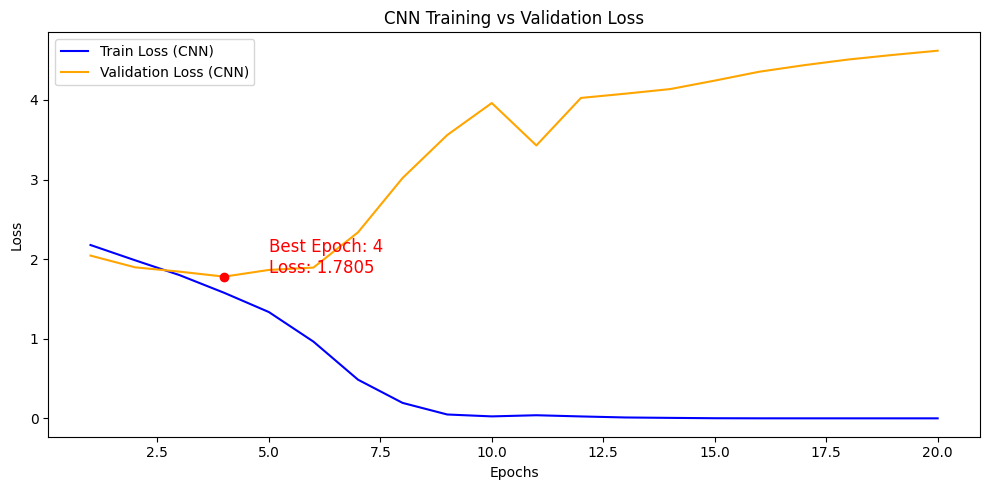

In [12]:
# Find the best epoch for CNN
best_cnn_epoch = np.argmin(cnn_val_losses) + 1  # Add 1 to match epoch numbering
best_cnn_val_loss = min(cnn_val_losses)

# Plot Training & Validation Loss for CNN
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), cnn_train_losses, label="Train Loss (CNN)", color='blue')
plt.plot(range(1, EPOCHS+1), cnn_val_losses, label="Validation Loss (CNN)", color='orange')

# Highlight the best epoch
plt.scatter(best_cnn_epoch, best_cnn_val_loss, color="red", zorder=5)
plt.text(best_cnn_epoch + 1, best_cnn_val_loss, f"Best Epoch: {best_cnn_epoch}\nLoss: {best_cnn_val_loss:.4f}",
         fontsize=12, color="red", verticalalignment="bottom")

# Add labels, legend, and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN Training vs Validation Loss")

# Show the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


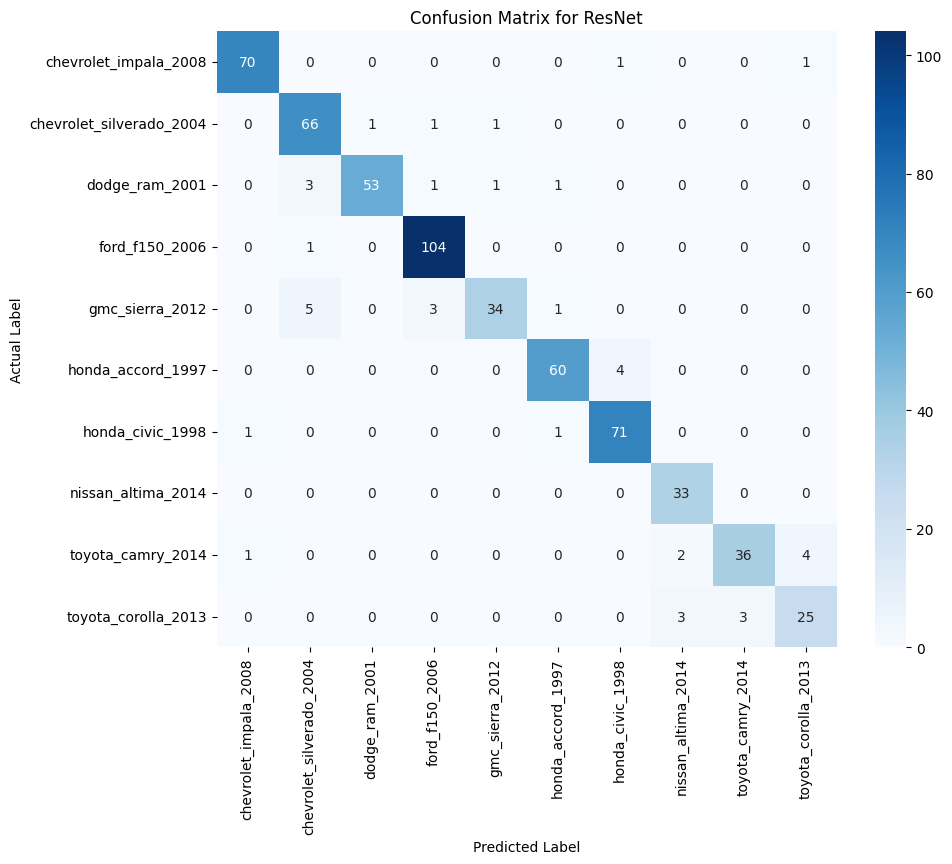

Most confused class pair for ResNet: ('gmc_sierra_2012', 'chevrolet_silverado_2004') with 5 misclassifications


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


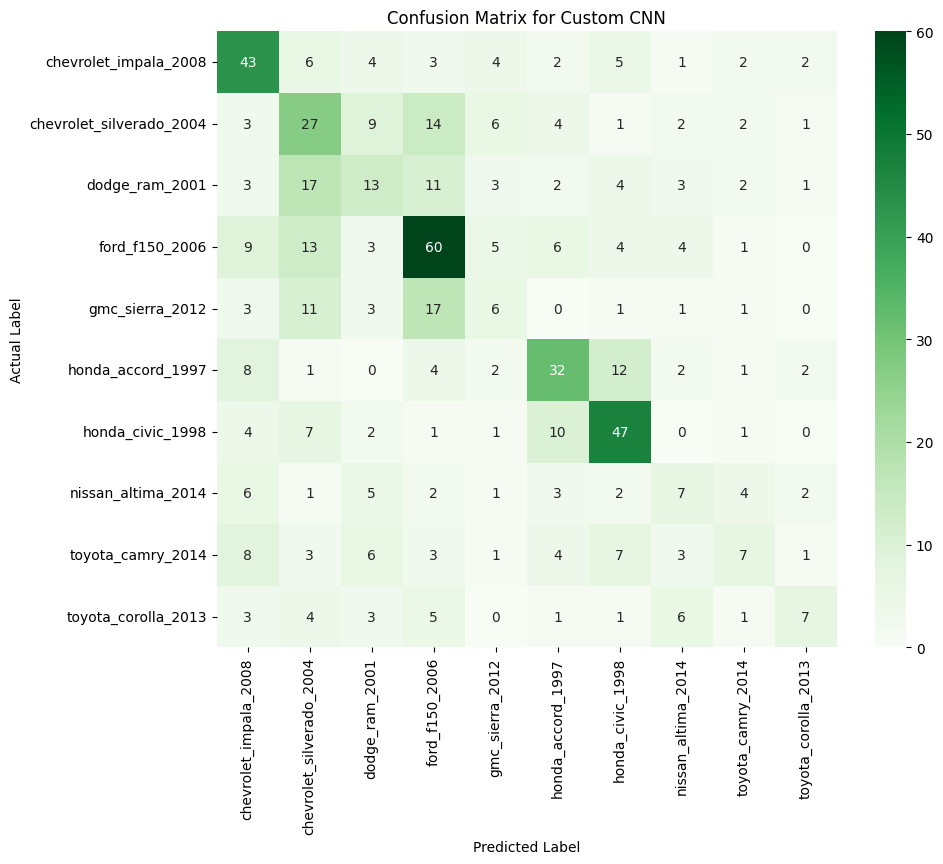

Most confused class pair for Custom CNN: ('dodge_ram_2001', 'chevrolet_silverado_2004') with 17 misclassifications


In [21]:

# --------------------------------------------------
# Confusion Matrix for ResNet Model with Class Labels
# --------------------------------------------------
model.eval()
y_true_resnet, y_pred_resnet = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true_resnet.extend(labels.cpu().numpy())
        y_pred_resnet.extend(predicted.cpu().numpy())

cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues",
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Confusion Matrix for ResNet")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Identify the most confused class pair for ResNet (ignoring the diagonal)
cm_resnet_no_diag = cm_resnet.copy()
np.fill_diagonal(cm_resnet_no_diag, 0)
max_index = np.unravel_index(np.argmax(cm_resnet_no_diag, axis=None), cm_resnet_no_diag.shape)
most_confused_count = cm_resnet_no_diag[max_index]
most_confused_pair = (full_dataset.classes[max_index[0]], full_dataset.classes[max_index[1]])
print(f"Most confused class pair for ResNet: {most_confused_pair} with {most_confused_count} misclassifications")

# --------------------------------------------------
# Confusion Matrix for Custom CNN Model with Class Labels
# --------------------------------------------------
cnn_model.eval()
y_true_cnn, y_pred_cnn = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true_cnn.extend(labels.cpu().numpy())
        y_pred_cnn.extend(predicted.cpu().numpy())

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Greens",
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("Confusion Matrix for Custom CNN")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Identify the most confused class pair for Custom CNN (ignoring the diagonal)
cm_cnn_no_diag = cm_cnn.copy()
np.fill_diagonal(cm_cnn_no_diag, 0)
max_index_cnn = np.unravel_index(np.argmax(cm_cnn_no_diag, axis=None), cm_cnn_no_diag.shape)
most_confused_count_cnn = cm_cnn_no_diag[max_index_cnn]
most_confused_pair_cnn = (full_dataset.classes[max_index_cnn[0]], full_dataset.classes[max_index_cnn[1]])
print(f"Most confused class pair for Custom CNN: {most_confused_pair_cnn} with {most_confused_count_cnn} misclassifications")





In [22]:
# --- Model Evaluation on Test Set ---
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.9324
Precision: 0.9337
Recall: 0.9324
F1 Score: 0.9317


In [23]:
# Assuming the mean and std used for normalization during the preprocessing
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Prepare a dictionary to store images by class
class_images = {i: [] for i in range(10)}  # Assuming there are 10 classes

# Loop through the dataset and classify images
for idx in range(len(test_dataset)):
    img, label = test_dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)

    # Get the model's prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)  # Get probabilities
        confidence, predicted_class = torch.max(probs, 1)

    # Add image to the corresponding class
    if predicted_class == label:  # Only add correct predictions
        class_images[label].append((img, label, predicted_class, confidence.item()))  # Store confidence score


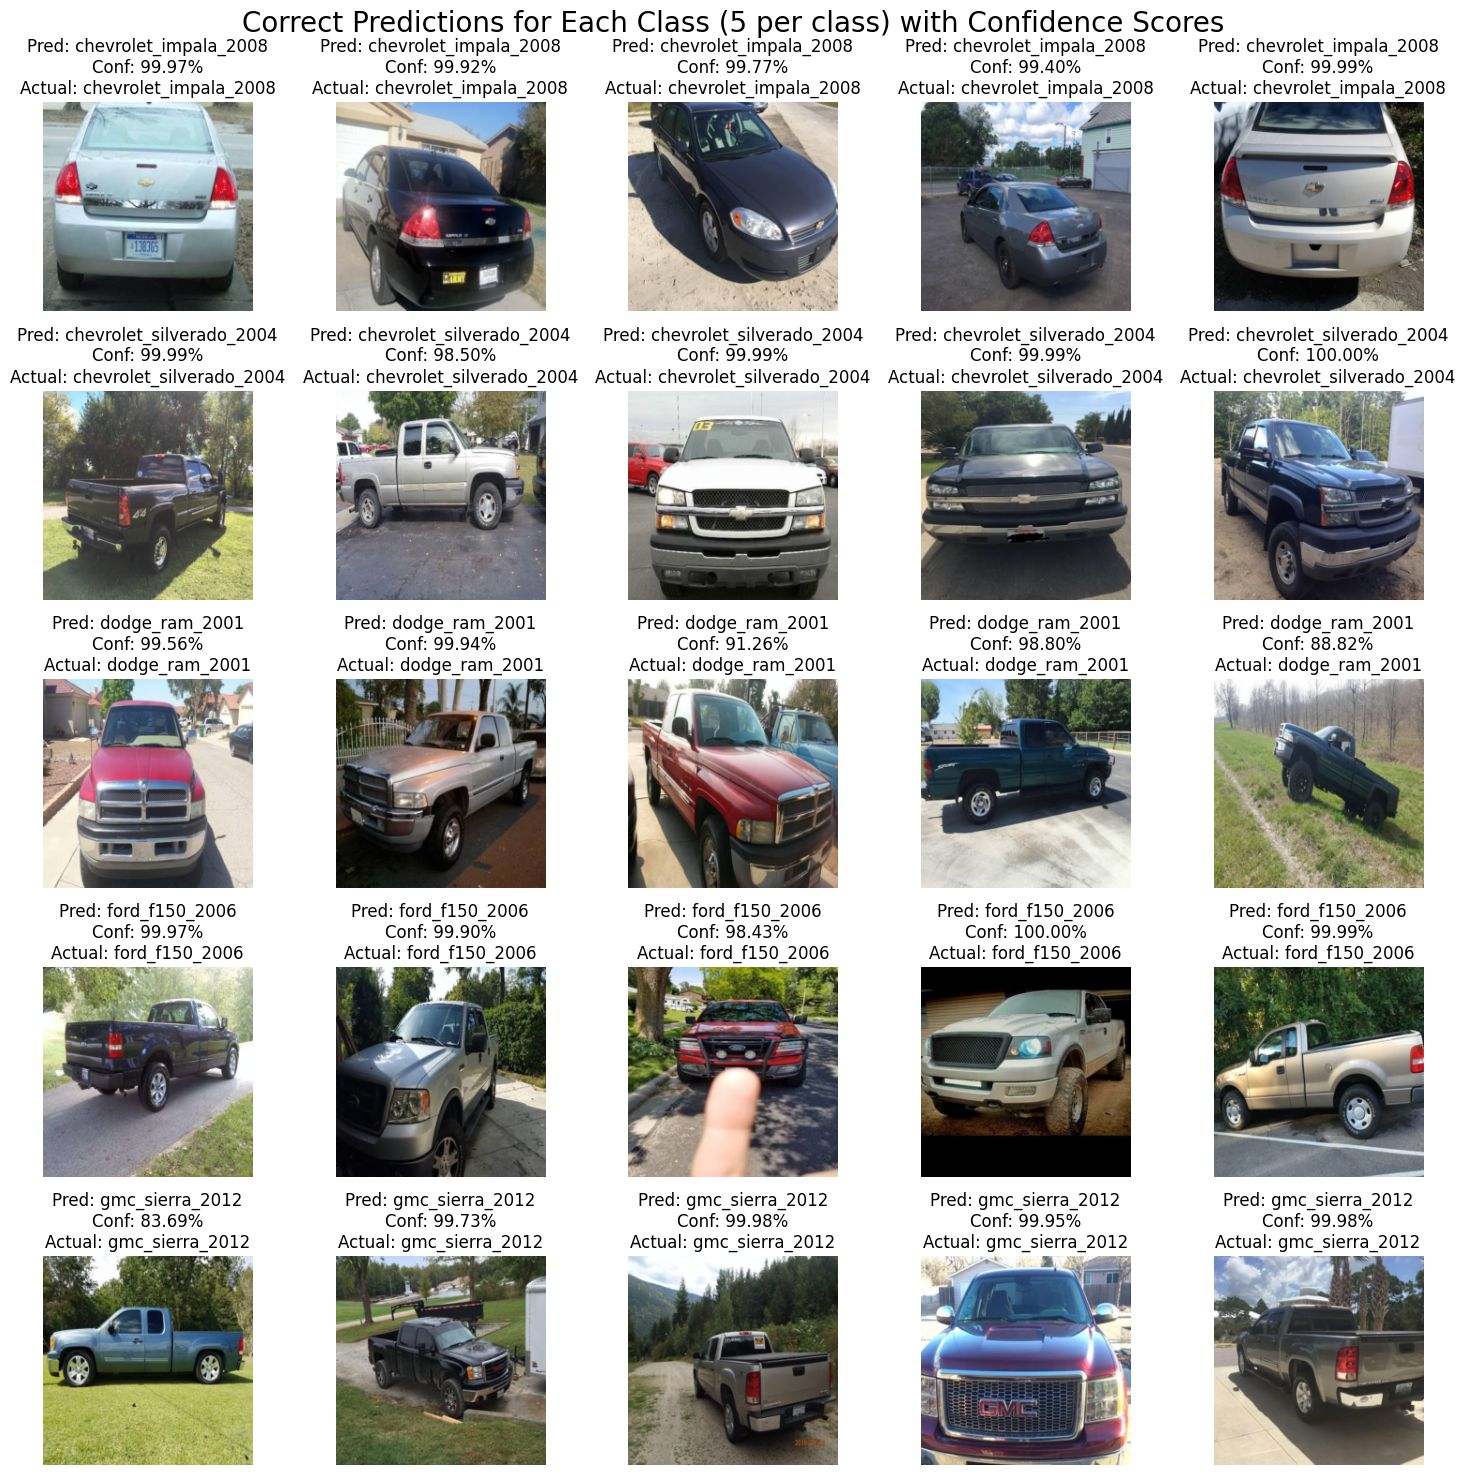

In [24]:
# Set up the plot
plt.figure(figsize=(15, 15))

# Add Titles
plt.suptitle("Correct Predictions for Each Class (5 per class) with Confidence Scores", fontsize=20)
plt.subplots_adjust(top=0.80)  # Adjust title placement to provide more space at the top

# Show 5 images per class, up to 10 classes
for class_idx in range(5):
    for i, (img, label, predicted_class, confidence) in enumerate(class_images[class_idx][:5]):  # Show 5 images per class
        # Denormalize the image
        img_denormalized = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

        plt.subplot(5, 5, class_idx * 5 + i + 1)  # 10 rows, 5 columns for the layout
        plt.imshow(img_denormalized.permute(1, 2, 0).cpu().numpy())  # Retain RGB format
        plt.axis('off')
        plt.title(f"Pred: {full_dataset.classes[predicted_class.item()]}\n"
                  f"Conf: {confidence*100:.2f}%\nActual: {full_dataset.classes[label]}")

# Display the Plot (tight_layout is called before show to prevent overlap)
plt.tight_layout()
plt.show()

In [ ]:
# Run the function to classify a random image
classify_random_image(model, test_dataset, device)
